**Fraud Anomaly Detection:**

*Objective:* Detect unusual transactions that could indicate fraud.

*Business problem:* Financial institutions lose billions due to fraud; anomaly detection helps flag suspicious activity early.

*Deliverable:* “Can we identify abnormal patterns in transactions using machine learning?”

The tasks to complete will include:
- Load the credit fraud dataset
- Do EDA
- Handle imbalance
- Training a few fraud detection models
- Evaluate results with the right metrics

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM

from imblearn.over_sampling import SMOTE

In [ ]:
# Downloading the dataset first from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("creditcard 2.csv")

print(df.head())
print(df['Class'].value_counts(normalize=True))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

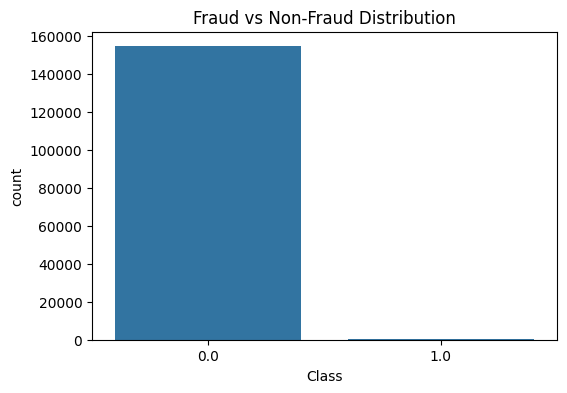

In [ ]:
# Fraud vs Non-Fraud
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Class")
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

- This plot shows the distribution of potential Non-Fraud (0.0) and Fraud (1.0) classes in the dataset.
- This shows visually, how the data is significantly imbalanced.

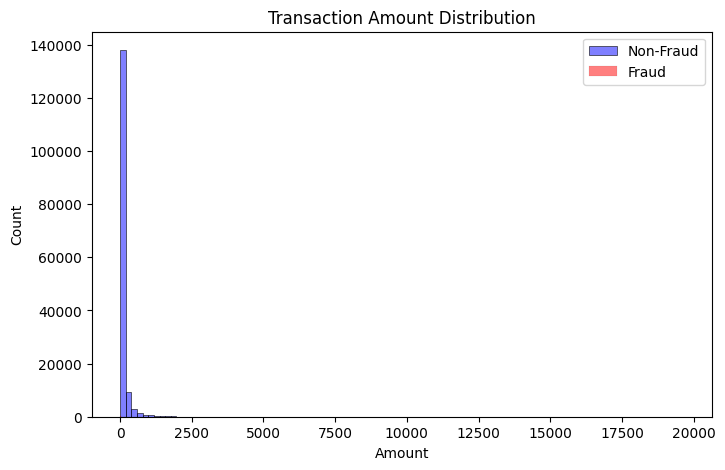

In [ ]:
# Amount distributions
plt.figure(figsize=(8,5))
sns.histplot(df[df['Class']==0]['Amount'], bins=100, color='blue', label='Non-Fraud', alpha=0.5)
sns.histplot(df[df['Class']==1]['Amount'], bins=100, color='red', label='Fraud', alpha=0.5)
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()

- A distribution of the non fraud and fraud amounts.

In [ ]:
print(y.isnull().sum())   # NaNs in target column
print(X.isnull().sum().sum())  # Any NaNs in features
print(df.isnull().sum().sum()) # Any NaNs in whole dataset

1
21
22


In [ ]:
X = X.dropna()
y = y.dropna()
y = y.loc[X.index]   # Keep alignment

In [ ]:
print(y.isnull().sum())   # NaNs in target column
print(X.isnull().sum().sum())  # Any NaNs in features
print(df.isnull().sum().sum()) # Any NaNs in whole dataset

0
0
22


In [ ]:
# Preprocessing

X = df.drop("Class", axis=1)
y = df["Class"]

X = X.dropna()
y = y.dropna()
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle imbalance with SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_scaled, y)
print(f"Before SMOTE: {y.value_counts()}")
print(f"After SMOTE: {pd.Series(y_res).value_counts()}")

Before SMOTE: Class
0.0    154282
1.0       338
Name: count, dtype: int64
After SMOTE: Class
0.0    154282
1.0    154282
Name: count, dtype: int64


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


===== Logistic Regression =====
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     30857
         1.0       0.98      0.94      0.96     30856

    accuracy                           0.96     61713
   macro avg       0.96      0.96      0.96     61713
weighted avg       0.96      0.96      0.96     61713

ROC AUC: 0.9906208673169817

===== Random Forest =====
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30857
         1.0       1.00      1.00      1.00     30856

    accuracy                           1.00     61713
   macro avg       1.00      1.00      1.00     61713
weighted avg       1.00      1.00      1.00     61713

ROC AUC: 0.9999996113949879


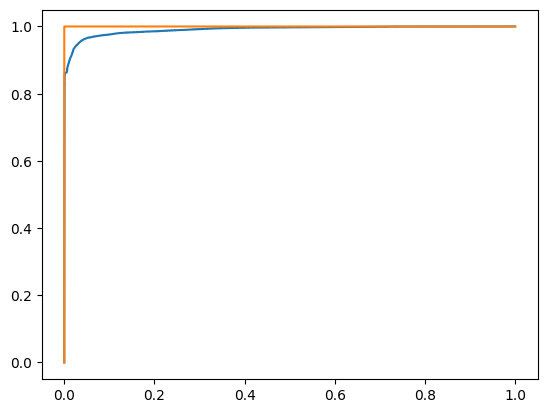

In [ ]:
# Supervised models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

- Using supervised models Logistic Regression and Random Forest, we achieve really good AUC scores (over 0.99) for both models.
- This also ties in with Recall (0.94) and f1-score (0.96) for LR, and Recall & f1-score of 1.0 using RF.
- As the data is labelled, the models perform well in learning and identifying the fraudulent transactions.

/tmp/ipython-input-2193939480.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


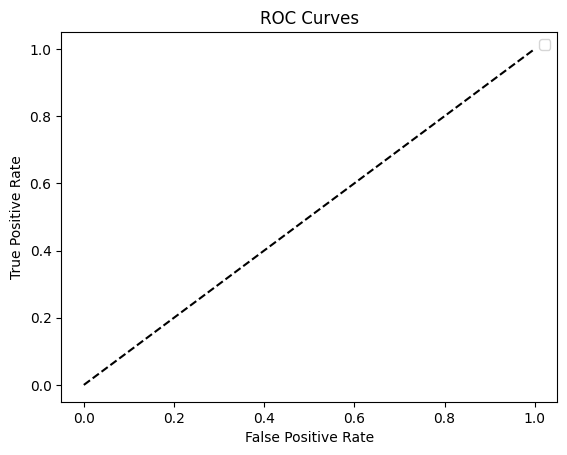

In [ ]:
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Unsupervised Models (Anomaly Detection)

In [ ]:
# Isolation Forest
iso = IsolationForest(contamination=0.002, random_state=42)
y_iso_pred = iso.fit_predict(X_test)
y_iso_pred = [1 if p == -1 else 0 for p in y_iso_pred]  # -1 = anomaly

print("\n===== Isolation Forest =====")
print(confusion_matrix(y_test, y_iso_pred))
print(classification_report(y_test, y_iso_pred))


===== Isolation Forest =====
[[30853     4]
 [30738   118]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     30857
         1.0       0.97      0.00      0.01     30856

    accuracy                           0.50     61713
   macro avg       0.73      0.50      0.34     61713
weighted avg       0.73      0.50      0.34     61713



In [ ]:
# One-Class SVM
ocsvm = OneClassSVM(nu=0.001, kernel="rbf")
ocsvm.fit(X_train)
y_ocsvm_pred = ocsvm.predict(X_test)
y_ocsvm_pred = [1 if p == -1 else 0 for p in y_ocsvm_pred]

print("\n===== One-Class SVM =====")
print(confusion_matrix(y_test, y_ocsvm_pred))
print(classification_report(y_test, y_ocsvm_pred))


===== One-Class SVM =====
[[30801    56]
 [30796    60]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     30857
         1.0       0.52      0.00      0.00     30856

    accuracy                           0.50     61713
   macro avg       0.51      0.50      0.34     61713
weighted avg       0.51      0.50      0.34     61713



- In contrast, with the data unlabelled, Isolation Forest & One-Class SVM model accuracy of 0.5 suggest they struggle to identify the fraudulent transactions. This is also seen from the low recall and f1-scores for both models.
- We can consider applying tuning to the models to increase certain parameters e.g Contamination rate (for IF) or Nu (OCSVM) to 1% to potentially increase the ability to identify fraud, However, while also increasing false-positives (which can have operational & customer impact). Fine balance is important and would require referring to domain-experts.

**Findings**
- We tested unsupervised anomaly detection, but due to the subtle nature of fraud in this dataset, supervised ML performed much better.
- As the data is very imbalanced, we needed to use SMOTE to introduce 50/50 balance. This can lead to the unsupervised model struggling to identify the fraud among a large pool of non-fraud transactions.
- Seeking guidance from fraud domain-experts.

- In conclusion, supervised ML is a better fit here at identifying fraud.
- However, anomaly detection without labels can still be valuable for detecting unknown future fraud types.